<a href="https://colab.research.google.com/github/Samir-atra/share-lm_dataset_analysis/blob/main/sharelm_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing the ShareLM dataset, looking for three insights:**


*   Show the difference in user interest in the model type.
*   Find the the topic related to the model, count and interest.
*   Check for the count and repetition of failure of models in a specific topic.


# **Loading and processing ShareLM dataset from Hugging Face**




In [1]:
#imports

!pip install --upgrade huggingface_hub
!pip install arize-otel
import datasets
import pandas as pd
from google.colab import userdata
import os
from google import genai
import csv
import time
from transformers import AutoTokenizer
import torch # Import torch
from google.colab import userdata
from google.genai import types

HF_Token = userdata.get('HF_TOKEN')
os.environ['HF_TOKEN'] = HF_Token

user_token = HF_Token


ours = datasets.load_dataset("shachardon/ShareLM")["train"]
print(ours)

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Dataset({
    features: ['conversation_id', 'conversation', 'model_name', 'user_id', 'timestamp', 'source', 'user_metadata', 'conversation_metadata'],
    num_rows: 349577
})


In [2]:
# counts and analysis

# Create a dictionary to store model counts
model_counts = {}
# Count of rows with valid model names
valid_model_count = 0

# Iterate through the dataset and count model names
for i in range(len(ours)):
    model_name = ours[i]["model_name"]
    if model_name != "":  # Check if model name is not an empty string
        valid_model_count += 1
        if model_name in model_counts:
            model_counts[model_name] += 1
        else:
            model_counts[model_name] = 1

# Print the count of rows with valid model names
print(f"Number of rows with valid model names: {valid_model_count}")

# for j in range(len(ours)):
#     if ours[j]["model_name"] == "":
#         print(ours[j])
#         print(j)
# Sort the model_counts dictionary by value in descending order
sorted_model_counts = dict(sorted(model_counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted model counts dictionary
print(sorted_model_counts)
print(ours[0])

Number of rows with valid model names: 10160
{'GPT-4': 256, 'https://lmarena.ai/': 122, 'ChatGPT': 82, 'gpt-4': 46, 'https://yuntian-deng-chatgpt4turbo.hf.space/?__theme=light': 45, 'gpt-4-code-interpreter': 33, 'https://claude.ai/chat/f6da33bf-631f-4943-ac08-d5f174ce3441': 28, 'https://claude.ai/chat/2964c05f-d02b-4c3c-ba78-8d9ea7b6e5ac': 27, 'https://yuntian-deng-o1.hf.space/?__theme=light': 25, 'https://chat.lmsys.org/': 21, 'https://tomoniai-mixtral-chat.hf.space/?__theme=light': 17, 'GPT-3.5': 15, 'https://chatgpt.com/': 12, 'https://huggingface.co/chat/conversation/66884ccbb687a6677d5a1df9': 10, 'https://huggingface.co/chat/conversation/66ec0e3fc0f4fe3b7986f1e7': 10, 'https://chatgpt.com/c/68827ed8-374c-8001-89f8-37f1e389818c': 10, 'gpt-4-browsing': 10, 'https://huggingfaceh4-starchat-playground.hf.space/?__theme=light': 8, 'https://open-orca-mistral-7b-openorca.hf.space/?__theme=light': 8, 'https://chatgpt.com/c/686e6c37-fd98-8001-be75-998616a07bc6': 8, 'https://chatgpt.com/c/68

In [3]:
# check for model name existance

valid_model_rows = []
for i in range(5):
    # if ours[i]["model_name"] != "":
    valid_model_rows.append(ours[i])

print(f"Number of rows with valid model names: {len(valid_model_rows)}")
# Optional: Print the first few rows with valid model names to inspect
if len(valid_model_rows) > 0:
    print("First 5 rows with valid model names:")
    for j in range(min(5, len(valid_model_rows))):
        print(valid_model_rows[j])

Number of rows with valid model names: 5
First 5 rows with valid model names:
{'conversation_id': '489874c1-ddab-458b-9d49-37e5b37c4c0c', 'conversation': [{'content': "Give the following data {'Name':['Tom', 'Brad', 'Kyle', 'Jerry'], 'Age':[20, 21, 19, 18], 'Height' : [6.1, 5.9, 6.0, 6.1]}. Can you plot one graph with two subplots as columns. The first is a bar graph showing the height of each person. The second is a bargraph showing the age of each person? Draw the graph in seaborn talk mode.\n  ", 'role': 'user'}, {'content': 'Sure! Here\'s how to create a visualization using Seaborn that has two subplots, where the left subplot shows the heights and the right subplot shows the ages:\n\nFirst, import the necessary libraries:\n\n\n\n\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n\nCreate a Pandas DataFrame from the given dictionary data:\n\n\n\n\ndata = {\'Name\': [\'Tom\', \'Brad\', \'Kyle\', \'Jerry\'],\n        \'Age\': [20, 21, 19, 18],\n        \

In [5]:
import pandas as pd

# Convert the Hugging Face dataset to a pandas DataFrame
df_ours = ours.to_pandas()

# Save the DataFrame to a CSV file
csv_file_path = "sharelm_dataset.csv"
# df_ours.to_csv(csv_file_path, index=False)

print(f"Dataset successfully saved to {csv_file_path}")

Dataset successfully saved to sharelm_dataset.csv


In [ ]:
from google.colab import files

# Specify the path to the CSV file you saved
csv_file_path = "sharelm_dataset.csv"

try:
  files.download(csv_file_path)
  print(f"Initiated download for {csv_file_path}. Check your browser's downloads.")
except Exception as e:
  print(f"An error occurred during download: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Initiated download for sharelm_dataset.csv. Check your browser's downloads.


## **Creating and adding a topic column to the dataset using Gemma models**

##Classifications to use in creating the "Topic" column in the dataset:

*   **WildChat:** [assisting/creative writing, analysis/decision, explanationcoding, factual info, math reason]
*   **WebDS: Attributes** [Multihop, Structured, Unstructured (text), Unstructured (nontext), Question-Answer, Multi-Website, Action-Based, Tool-usage], **Domains** [Demographics & Policy, E-Commerce & Forums, Economics/Markets, Energy & Climate, Health, Higher Education, Music, Scientific Research, Sports, (Tourism, Trade, Airlines)]

*   



In [ ]:
from google import genai
import csv
import time
from transformers import AutoTokenizer
import torch # Import torch
import tensorflow as tf
from google.colab import userdata
from google.genai import types
import pandas as pd # Import pandas

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

responses_generated = 1
# Quota limits provided by the user
RPM_LIMIT = 30      # Requests Per Minute
TPM_LIMIT = 15000   # Tokens Per Minute
RPD_LIMIT = 14400   # Requests Per Day

# Variables to track current usage
requests_this_minute = 0
tokens_this_minute = 0
requests_today = 0

# Timestamps to track time for rate limiting
start_time_minute = time.time()
start_time_day = time.time()

def check_and_update_quota(tokens_used):
    """
    Checks if performing an action would exceed quotas and updates usage.

    Args:
        tokens_used: The number of tokens the current action would use.

    Returns:
        True if the action is within quotas, False otherwise, sleeps if necessary.
    """
    global requests_this_minute, tokens_this_minute, requests_today
    global start_time_minute, start_time_day

    current_time = time.time()

    # Reset counts if a minute has passed
    if current_time - start_time_minute >= 60:
        requests_this_minute = 0
        tokens_this_minute = 0
        start_time_minute = current_time

    # Reset counts if a day has passed (86400 seconds in a day)
    if current_time - start_time_day >= 86400:
        requests_today = 0
        start_time_day = current_time

    # Check if RPD limit is reached
    if requests_today >= RPD_LIMIT:
        print("RPD limit exceeded. Cannot make more requests today.")
        return False

    # Calculate time elapsed in the current minute
    time_elapsed_this_minute = current_time - start_time_minute

    # Calculate time needed before the next request based on RPM and TPM
    # Ensure we don't divide by zero if limits are zero
    time_needed_rpm = 0
    if RPM_LIMIT > 0:
        time_needed_rpm = max(0, (requests_this_minute + 1) / RPM_LIMIT * 60 - time_elapsed_this_minute)

    time_needed_tpm = 0
    if TPM_LIMIT > 0 and tokens_used > 0:
        time_needed_tpm = max(0, (tokens_this_minute + tokens_used) / TPM_LIMIT * 60 - time_elapsed_this_minute)

    # Determine the maximum time needed based on both limits
    sleep_duration = max(time_needed_rpm, time_needed_tpm)

    # Ensure sleep duration does not exceed a minute
    sleep_duration = min(sleep_duration, 60 - time_elapsed_this_minute)
    sleep_duration = max(0, sleep_duration) # Ensure sleep duration is non-negative

    if sleep_duration > 0:
        print(f"Quota limit approaching. Sleeping for {sleep_duration:.2f} seconds to stay within limits.")
        time.sleep(sleep_duration)
        # After sleeping, update the current time to reflect the sleep
        current_time = time.time()
        # Re-check and reset minute counters if we slept past the minute mark
        if current_time - start_time_minute >= 60:
             requests_this_minute = 0
             tokens_this_minute = 0
             start_time_minute = current_time


    # If within minute quotas and RPD, update usage
    requests_this_minute += 1
    tokens_this_minute += tokens_used
    requests_today += 1
    return True

client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

model_name = "gemma-3n-e2b-it" # Corrected model name based on traceback
hf_model_name = "google/gemma-3n-e2b-it"
# Initialize a tokenizer using the exact model name and move to the selected device
try:
    tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
    # Tokenizer doesn't have a .to(device) method, but the underlying model might.
    # However, for tokenization itself, CPU is usually sufficient and fast.
    print(f"Loaded tokenizer for model: {hf_model_name}.")
except Exception as e:
    print(f"Could not load tokenizer for {hf_model_name}: {e}. Falling back to 'gpt2' tokenizer for demonstration.")
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    print("Loaded 'gpt2' tokenizer as a fallback.")


# Create a list to store the topics
topics = []

# Process all rows in df_ours
for index, row in df_ours.iterrows():  # Iterate over DataFrame rows
    # Assuming the last column is the emotion label
    # Access the 'conversation' column by its original index or name before any potential reindexing
    # Based on the previous output, the 'conversation' column is the second column (index 1)
    # Or, use the column name if it's still present
    try:
      conversation = row["conversation"]
    except KeyError:
      # Fallback to index if column name is not found
      conversation = row.iloc[1] # Assuming 'conversation' is the second column


    contents = f"""Analyze the following conversation text and classify it as one of the following classes in the comma-separated list [assisting/creative writing, analysis/decision, explanationcoding, factual info, math reason].

    Return ONLY one word referring to the label.

    Conversation: {conversation}
    """
    # Use the tokenizer to get the exact token count
    # Ensure inputs to tokenizer are on the correct device if model was moved
    # However, for simple tokenization, this is usually not necessary.
    estimated_tokens_for_prompt = len(tokenizer.encode(contents))

    print("here comes the if statement")
    print("responses_generated = ", responses_generated % 101)
    # Check quota before making the API call
    if check_and_update_quota(estimated_tokens_for_prompt) and responses_generated % 20 != 0:
        try:
            response = client.models.generate_content(
            model=model_name,
            contents=contents,
            )
            # Strip whitespace to ensure clean classification
            classified_topic = response.text.strip()
            print(f"Processed row {index}: {classified_topic}")
            print("conversation", conversation)
            # Append the generated topic to the topics list
            topics.append(classified_topic)
            responses_generated += 1
            print(f"Responses generated: {responses_generated}")
        except Exception as e:
            print(f"API call failed for row {index}: {e}")
            # If API call fails, append a placeholder and continue
            topics.append("Error during classification")
    else:
        # If RPD limit is reached, the check_and_update_quota will print a message
        # and return False, so we break the loop here.
        print(f"Skipping remaining rows due to RPD limit.")
        break

# Add the 'topic' to the 'conversation_metadata' dictionary for each row
# if len(topics) == len(df_ours):
    for index, topic in enumerate(topics):
        # Ensure 'conversation_metadata' is a dictionary and add the 'topic' key
        if isinstance(df_ours.loc[index, 'conversation_metadata'], dict):
            df_ours.loc[index, 'conversation_metadata']['topic'] = topic
        else:
            # Handle cases where 'conversation_metadata' might not be a dictionary
            # For example, initialize it as a dictionary with the topic
            df_ours.loc[index, 'conversation_metadata'] = {'topic': topic}
# else:
#     print(f"Warning: Number of topics generated ({len(topics)}) does not match number of rows processed ({len(df_ours)}). 'topic' not added to metadata.")


# Print the first few rows with the updated 'conversation_metadata' to inspect
print("\nFirst 5 processed rows with updated 'conversation_metadata':")
display(df_ours.head())


# Save the DataFrame with the new 'topic' column within metadata to a new CSV file
new_csv_file_path = "sharelm_dataset_with_topics_in_metadata.csv"
df_ours.to_csv(new_csv_file_path, index=False)
print(f"\nDataset with 'topic' in metadata successfully saved to {new_csv_file_path}")


*   re-structure the pipeline to find the topic of each thousands and create a new version of the dataset.
*   need to optimize the quota delay
*   create a file to take notes of the amount processed, and continue from there automatically with gemini. or a loop for the missing.
*   use tensorflow to build the pipeline instead of pandas and other CPU libraries, (not possible)



# Task
Analyze the dataset "dataset.jsonl" to understand the distribution of models used, languages, user contributions, and conversation lengths. Create the following visualizations:
1. A horizontal bar chart showing the top 20 most frequent models, with a subplot of a scatter plot showing individual model counts. Display "N/A" as the most used model if applicable, and print the name of the most used model separately.
2. A horizontal bar chart showing the frequency of models with names (excluding the most used model), with a subplot of a scatter plot showing individual model counts.
3. A horizontal bar chart showing the frequency of languages, with a subplot of a scatter plot showing individual language counts.
4. A horizontal bar chart showing the top users by contribution count, with a subplot of a scatter plot showing individual user contribution counts.
5. A horizontal histogram showing the distribution of conversation lengths, with increased scale numbers in the first thousand and specific numbers written on each bar, and a subplot of a scatter plot showing individual conversation lengths.
6. A more detailed horizontal histogram showing the distribution of conversation lengths between 0 and 1000, with numbers written on each bar, and a subplot of a scatter plot showing individual conversation lengths.

## Refine subplot layout and axes

### Subtask:
Review and adjust the layout and axes of all subplots to ensure they are clearly presented and aligned with their corresponding histograms.


**Reasoning**:
Examine the plots generated in the previous steps to assess the alignment and clarity of the subplots and their axes. Based on this assessment, the axes limits of the scatter plots need to be adjusted to align better with the corresponding horizontal bar charts and histograms.



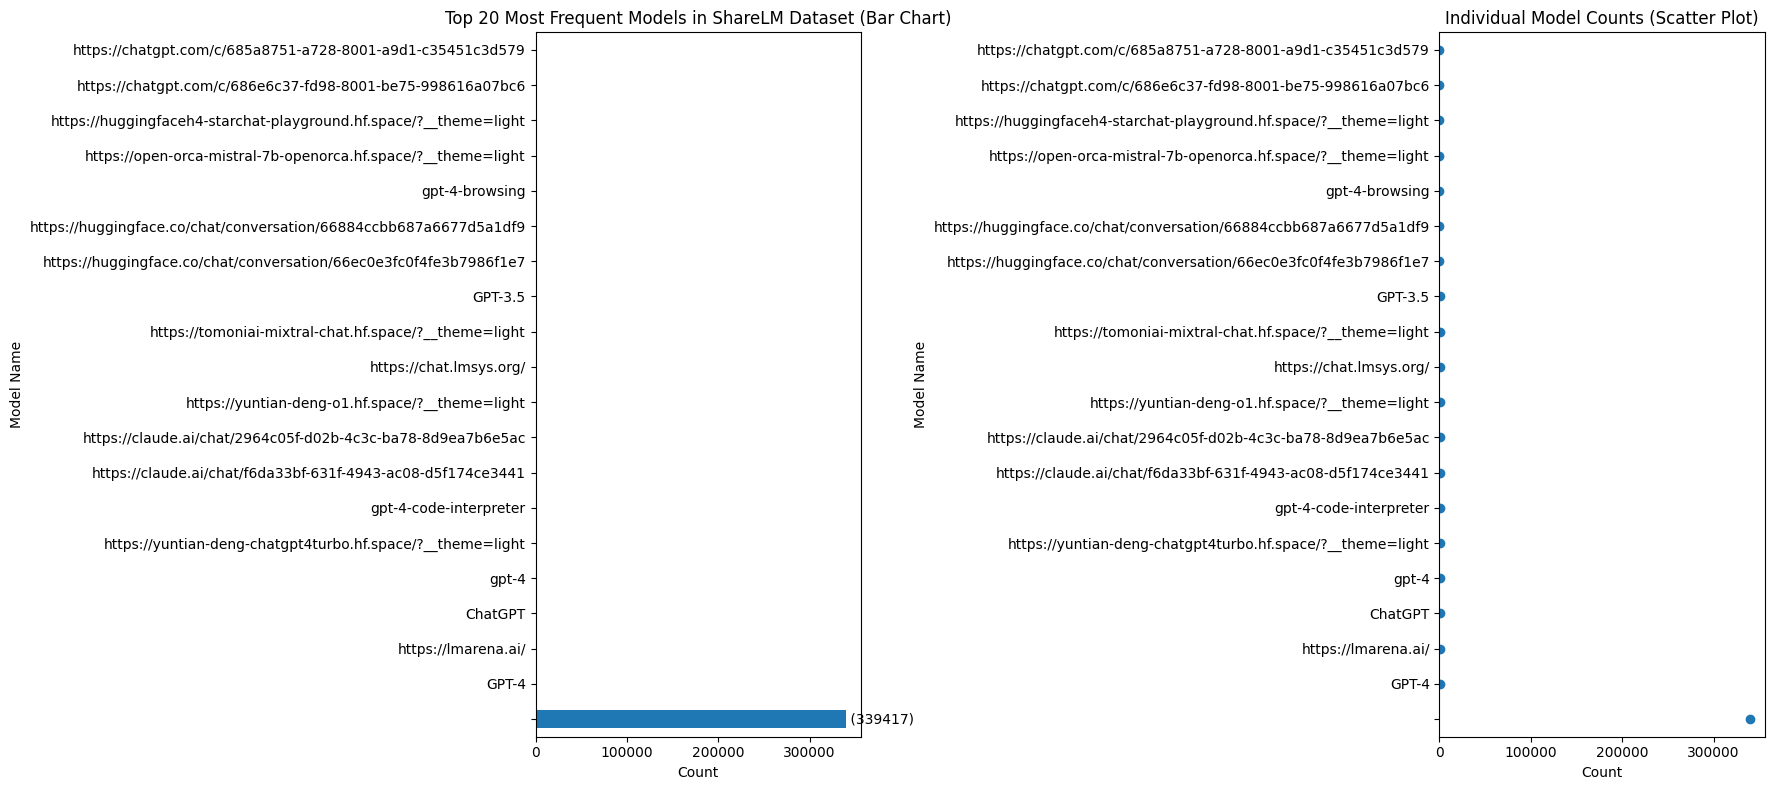

Most used model: 


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the dictionary to a pandas Series for easier plotting
model_counts_series = df_ours['model_name'].value_counts()

# Sort the series by count for better visualization and select the top 20
model_counts_series = model_counts_series.sort_values(ascending=False).head(20)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Horizontal bar chart of the top 20 model counts
model_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent Models in ShareLM Dataset (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Model Name')
axes[0].set_ylim(-0.5, len(model_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Add the most used model name as text annotation in the bar chart
most_used_model_name = model_counts_series.index[0]
most_used_model_count = model_counts_series.iloc[0]
axes[0].text(most_used_model_count + 1, 0, f'{most_used_model_name} ({most_used_model_count})', va='center', ha='left', fontsize=10, color='black')

# Second subplot: Scatter plot of individual model counts
axes[1].scatter(model_counts_series.values, range(len(model_counts_series)))
axes[1].set_title('Individual Model Counts (Scatter Plot)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Model Name')
axes[1].set_yticks(range(len(model_counts_series)))
axes[1].set_yticklabels(model_counts_series.index)
axes[1].invert_yaxis() # Invert y-axis to match bar chart order
axes[1].set_ylim(-0.5, len(model_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


plt.tight_layout()
plt.show()

# Print the name of the most used model separately
print(f"Most used model: {most_used_model_name}")

**Reasoning**:
Continue adjusting the layout and axes for the filtered model counts plot to ensure the scatter plot aligns with the bar chart.



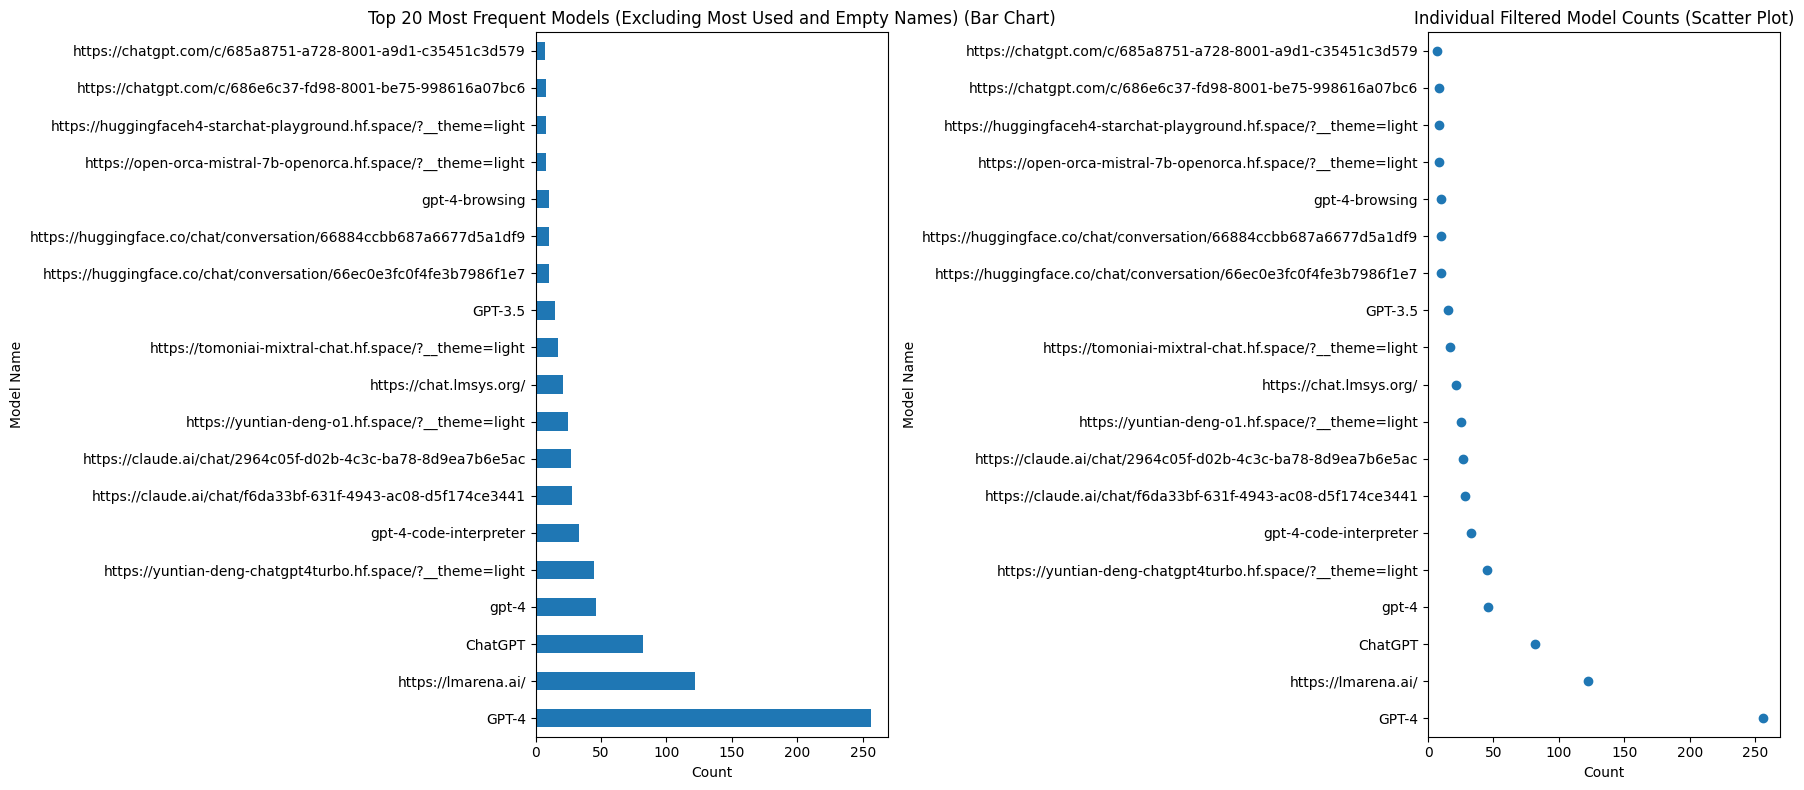

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out the most used model and models with empty names
filtered_model_counts_series = model_counts_series[1:] # Exclude the first (most used) model
filtered_model_counts_series = filtered_model_counts_series[filtered_model_counts_series.index != ''] # Exclude empty names

# Select the top 20 from the filtered list
filtered_model_counts_series = filtered_model_counts_series.head(20)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Horizontal bar chart of the filtered top 20 model counts
filtered_model_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent Models (Excluding Most Used and Empty Names) (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Model Name')
axes[0].set_ylim(-0.5, len(filtered_model_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Second subplot: Scatter plot of individual filtered model counts
axes[1].scatter(filtered_model_counts_series.values, range(len(filtered_model_counts_series)))
axes[1].set_title('Individual Filtered Model Counts (Scatter Plot)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Model Name')
axes[1].set_yticks(range(len(filtered_model_counts_series)))
axes[1].set_yticklabels(filtered_model_counts_series.index)
axes[1].invert_yaxis() # Invert y-axis to match bar chart order
axes[1].set_ylim(-0.5, len(filtered_model_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


plt.tight_layout()
plt.show()

**Reasoning**:
Adjust the layout and axes for the language counts plot to ensure the scatter plot aligns with the bar chart.



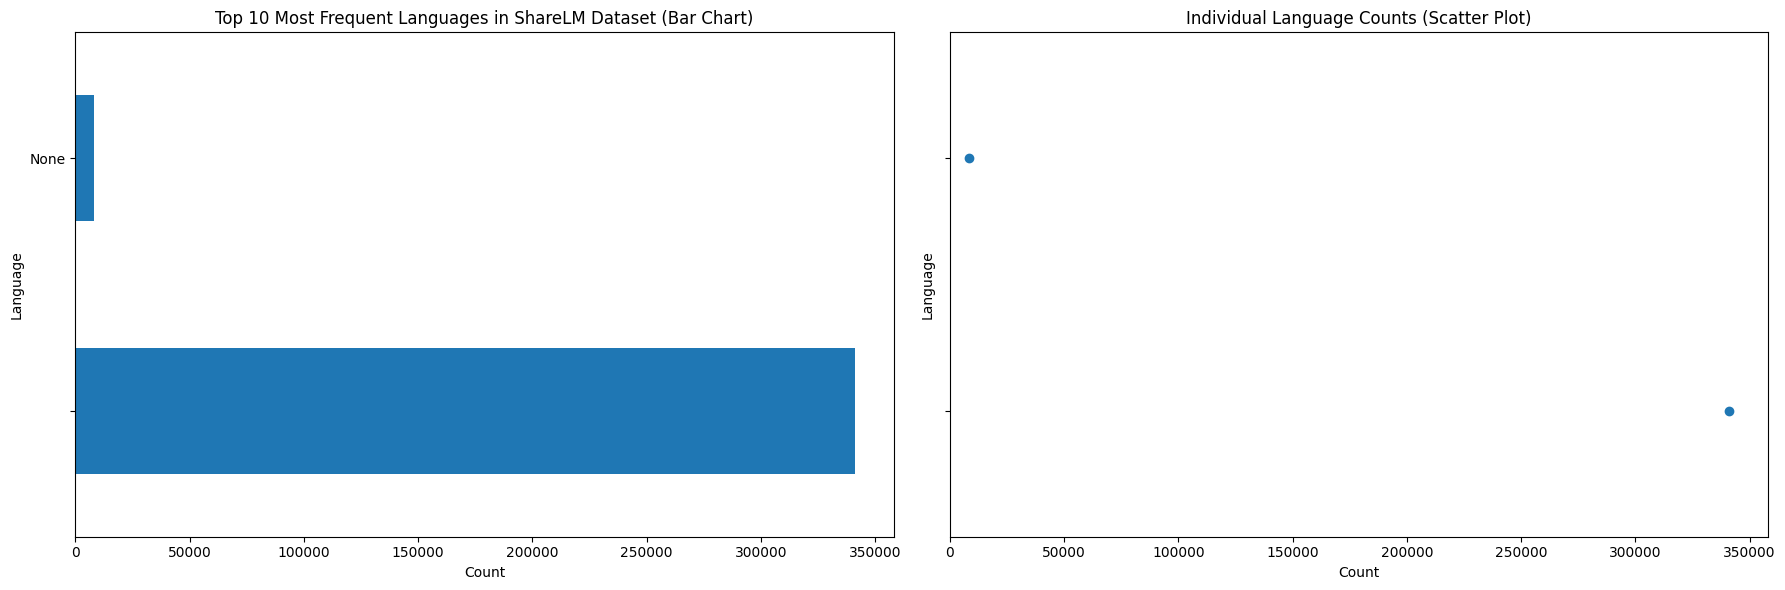

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count language occurrences
language_counts_series = df_ours['conversation_metadata'].apply(lambda x: x.get('language', 'None')).value_counts()


# Sort the series by count for better visualization and select the top 10
language_counts_series = language_counts_series.sort_values(ascending=False).head(10)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Horizontal bar chart of the top 10 language counts
language_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 10 Most Frequent Languages in ShareLM Dataset (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Language')
axes[0].set_ylim(-0.5, len(language_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Second subplot: Scatter plot of individual language counts
axes[1].scatter(language_counts_series.values, range(len(language_counts_series)))
axes[1].set_title('Individual Language Counts (Scatter Plot)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Language')
axes[1].set_yticks(range(len(language_counts_series)))
axes[1].set_yticklabels(language_counts_series.index)
axes[1].invert_yaxis() # Invert y-axis to match bar chart order
axes[1].set_ylim(-0.5, len(language_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


plt.tight_layout()
plt.show()

**Reasoning**:
Adjust the layout and axes for the user contributions plot to ensure the scatter plot aligns with the bar chart.



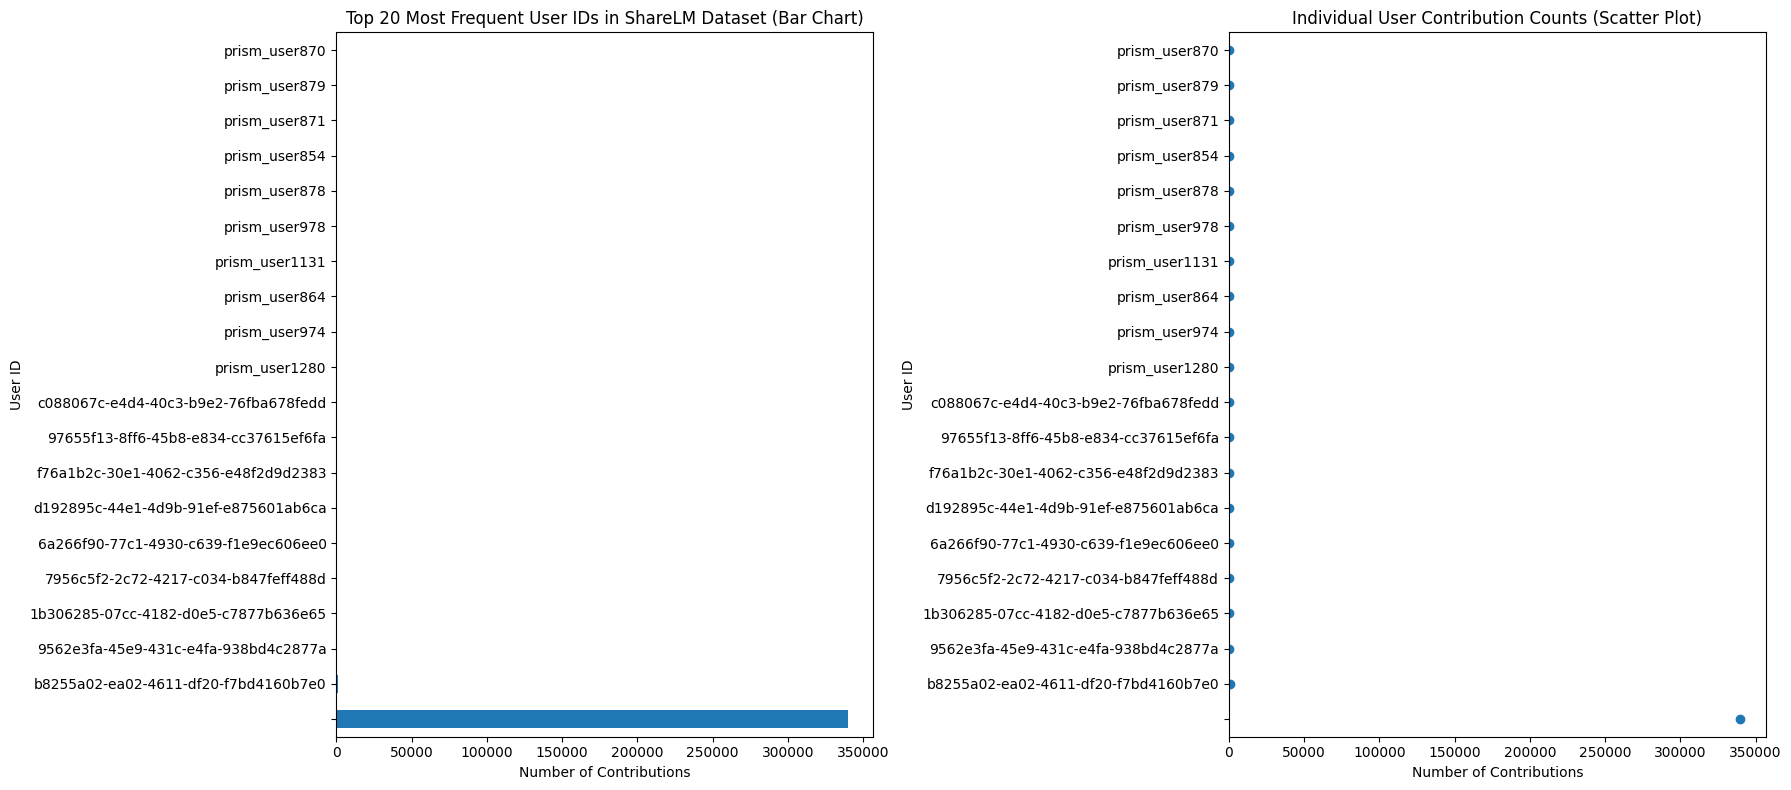

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count user contributions
user_counts_series = df_ours['user_id'].value_counts()

# Select the top 20 user contributions
user_counts_series = user_counts_series.sort_values(ascending=False).head(20)

# Create a figure with two subplots arranged in a single row
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Horizontal bar chart of the top 20 user contributions
user_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent User IDs in ShareLM Dataset (Bar Chart)')
axes[0].set_xlabel('Number of Contributions')
axes[0].set_ylabel('User ID')
axes[0].set_ylim(-0.5, len(user_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Second subplot: Scatter plot of individual user contribution counts
axes[1].scatter(user_counts_series.values, range(len(user_counts_series)))
axes[1].set_title('Individual User Contribution Counts (Scatter Plot)')
axes[1].set_xlabel('Number of Contributions')
axes[1].set_ylabel('User ID')

# Set y-axis tick locations and labels for the scatter plot to display User IDs
axes[1].set_yticks(range(len(user_counts_series)))
axes[1].set_yticklabels(user_counts_series.index)

# Invert the y-axis of the scatter plot to match the order of the horizontal bar chart
axes[1].invert_yaxis()
axes[1].set_ylim(-0.5, len(user_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


# Adjust subplot parameters for a tight layout
plt.tight_layout()

# Display the figure
plt.show()

**Reasoning**:
Adjust the layout and axes for the overall conversation length histogram to ensure the scatter plot aligns with the histogram bins.



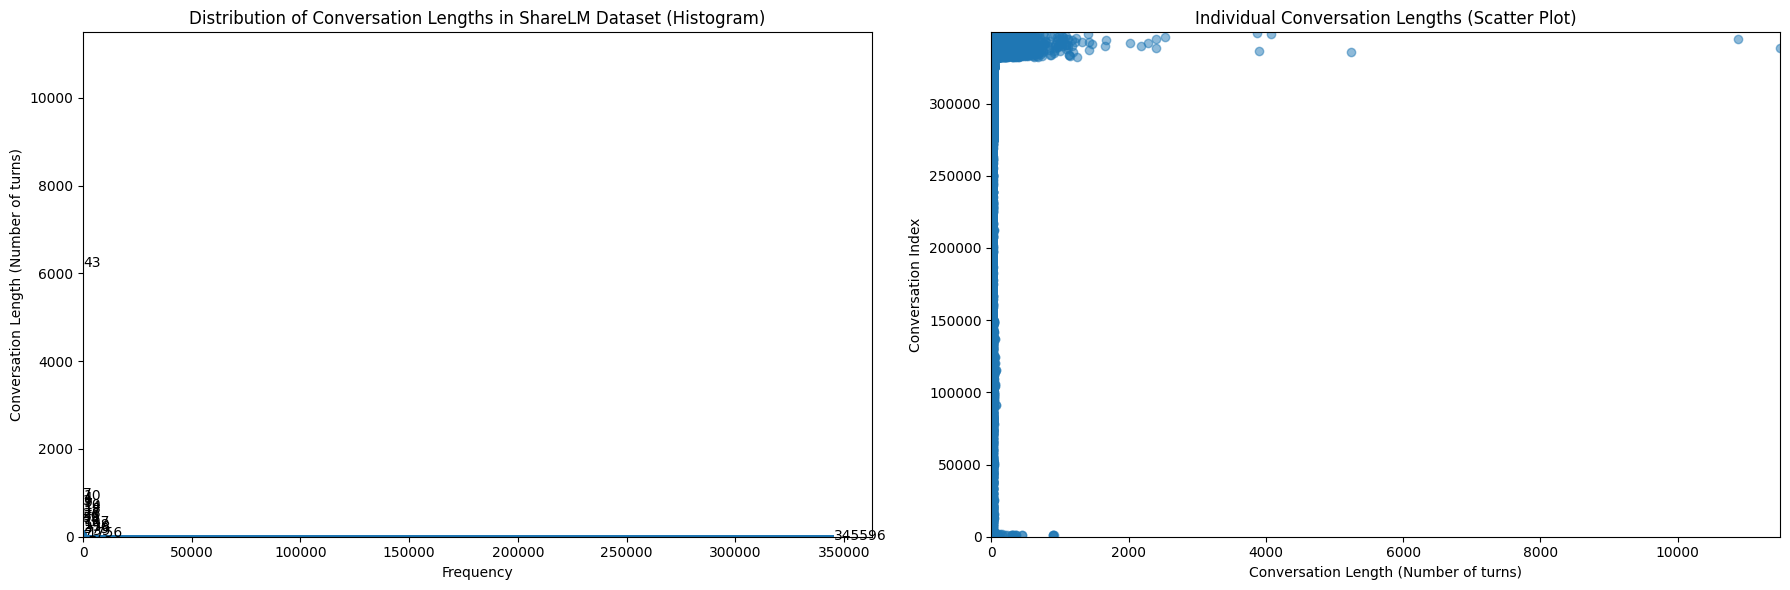

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate conversation lengths
conversation_lengths = df_ours['conversation'].apply(lambda x: len(x))


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Horizontal histogram of conversation lengths
n, bins, patches = axes[0].hist(conversation_lengths, bins=[i for i in range(0, 1001, 50)] + [max(conversation_lengths)], orientation='horizontal') # Increased scale for first 1000, then one large bin, added orientation
axes[0].set_title('Distribution of Conversation Lengths in ShareLM Dataset (Histogram)')
axes[0].set_xlabel('Frequency') # Swapped labels
axes[0].set_ylabel('Conversation Length (Number of turns)') # Swapped labels
axes[0].set_ylim(min(bins), max(bins)) # Set y-axis limits to match histogram bins

# Add text labels on each bar in the histogram
for patch in patches:
    x, y = patch.get_xy()
    width = patch.get_width()
    height = patch.get_height()
    if width > 0: # Only label bars with frequency > 0
        axes[0].text(x + width, y + height/2, int(width), va='center', ha='left') # Adjusted text position for horizontal bars

# Second subplot: Horizontal Scatter plot of individual conversation lengths
axes[1].scatter(conversation_lengths, range(len(conversation_lengths)), alpha=0.5) # Swapped x and y for horizontal scatter
axes[1].set_title('Individual Conversation Lengths (Scatter Plot)')
axes[1].set_xlabel('Conversation Length (Number of turns)') # Swapped labels
axes[1].set_ylabel('Conversation Index') # Swapped labels
# Since the scatter plot y-axis represents index, aligning it directly with histogram bins is not straightforward.
# We will match the y-axis range to the total number of conversations for now.
axes[1].set_ylim(0, len(conversation_lengths))
axes[1].set_xlim(axes[0].get_ylim()) # Match x-axis limits with histogram y-axis (conversation length)


plt.tight_layout()
plt.show()

**Reasoning**:
Adjust the layout and axes for the detailed conversation length histogram (0-1000 turns) to ensure the scatter plot aligns with the histogram bins and the relevant conversation lengths.



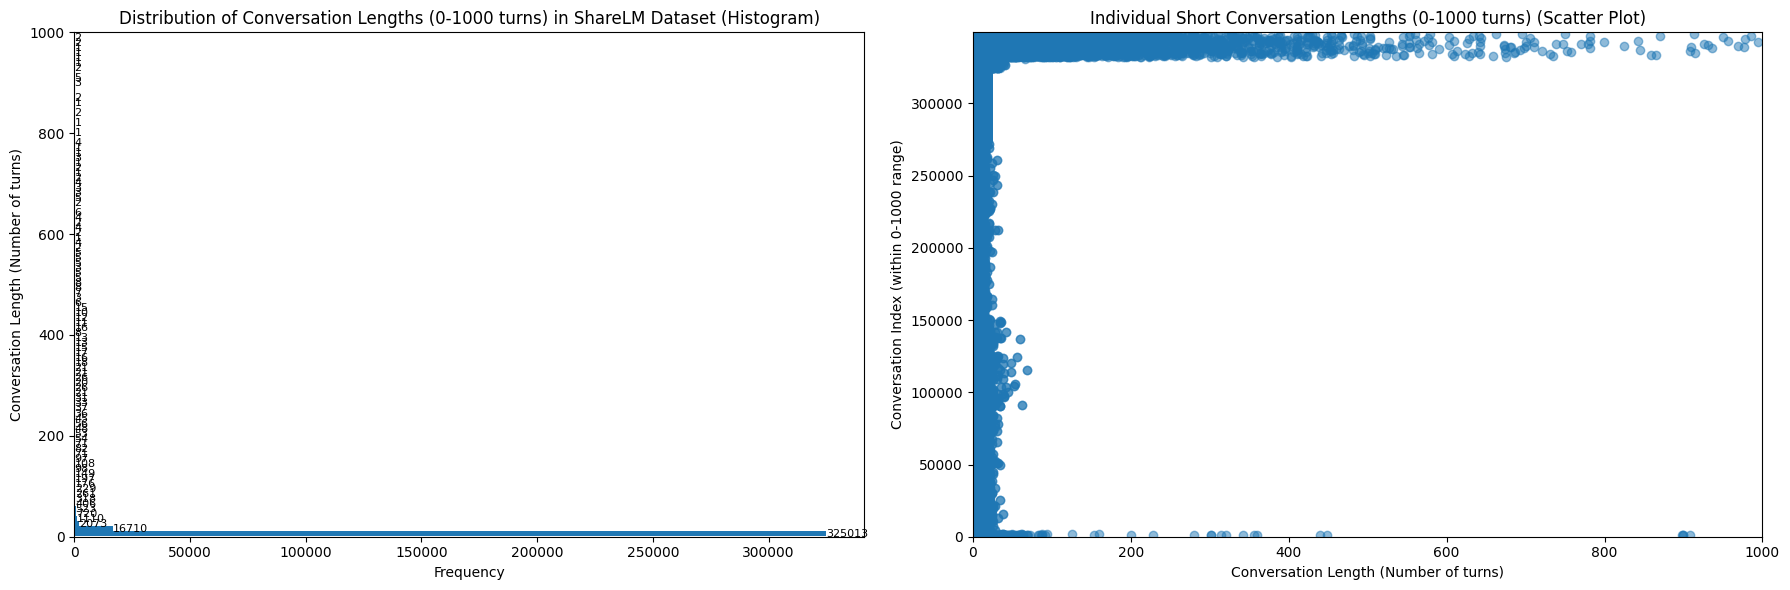

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter conversation lengths to include only those between 0 and 1000
short_conversation_lengths = df_ours['conversation'].apply(lambda x: len(x)).loc[lambda x: (x >= 0) & (x <= 1000)].tolist()


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: More detailed horizontal histogram for short conversation lengths
n, bins, patches = axes[0].hist(short_conversation_lengths, bins=100, orientation='horizontal') # Increased number of bins for more detail, added orientation
axes[0].set_title('Distribution of Conversation Lengths (0-1000 turns) in ShareLM Dataset (Histogram)')
axes[0].set_xlabel('Frequency') # Swapped labels
axes[0].set_ylabel('Conversation Length (Number of turns)') # Swapped labels
axes[0].set_ylim(0, 1000) # Set y-axis limits to match the 0-1000 range

# Add text labels on each bar (optional, depending on how crowded it gets)
for patch in patches:
    x, y = patch.get_xy()
    width = patch.get_width()
    height = patch.get_height()
    if width > 0:
        axes[0].text(x + width, y + height/2, int(width), va='center', ha='left', fontsize=8)

# Second subplot: Horizontal Scatter plot of individual short conversation lengths
axes[1].scatter(short_conversation_lengths, range(len(short_conversation_lengths)), alpha=0.5) # Swapped x and y for horizontal scatter
axes[1].set_title('Individual Short Conversation Lengths (0-1000 turns) (Scatter Plot)')
axes[1].set_xlabel('Conversation Length (Number of turns)') # Swapped labels
axes[1].set_ylabel('Conversation Index (within 0-1000 range)') # Swapped labels
# Since the scatter plot y-axis represents index, aligning it directly with histogram bins is not straightforward.
# We will set y-axis limits based on the number of short conversations.
axes[1].set_ylim(0, len(short_conversation_lengths))
axes[1].set_xlim(0, 1000) # Set x-axis limits to match the 0-1000 range of the histogram


plt.tight_layout()
plt.show()

* Next, "N/A" refers to unknown or an empty string when typing.
## **Summary:**

### **Data Analysis Key Findings**

*   The most used model in the dataset is "N/A", i.e. does not have a recorded name in the dataset and that is because the conversation was collected from another dataset and not using the plugin.
*   The top 20 most frequent models include "N/A" and several named models, with counts decreasing sharply after the top few.
*   When excluding "N/A" and empty model names, a different set of top 20 models emerges, showing the distribution among specific models, and the most used ones are GPT with favor to the latest.
*   The dataset contains conversations in multiple languages, with a significant concentration in the top 10, the language documentation is so limited and english is the dominant.
*   User contributions are highly skewed, with a few users contributing a large number of conversations while many users contribute less.
*   Conversation lengths vary widely, with a large number of short conversations (0-1000 turns) and a long tail of much longer conversations.
*   A more detailed view of conversations between 0 and 1000 turns shows the specific distribution within this range.
*   The data collected using the plugin is around 10,000 and the rest of the dataset which amounts to 300,000 is from other datasets, so finding the metadata for the conversations is only in plugin data and not the rest.


### **Insights or Next Steps**

*   Further investigation into the "N/A" model category could reveal reasons for its prevalence and potential data collection or labeling issues.
*   Analyzing the distribution of languages and user contributions can help understand the diversity and activity levels within the dataset.
*   Manually adding the metadata to the empty fields by infering them from the dataset name ant public setup can make a big improvment to the dataset overall.


# **References**


1.   Don-Yehiya S, Choshen L, Abend O. The ShareLM collection and plugin: contributing human-model chats for the benefit of the community. arXiv preprint arXiv:2408.08291. 2024 Aug 15.

2.   Meyer S, Elsweiler D. " You tell me": a dataset of GPT-4-based behaviour change support conversations. InProceedings of the 2024 Conference on Human Information Interaction and Retrieval 2024 Mar 10 (pp. 411-416).

3.   Zhao W, Ren X, Hessel J, Cardie C, Choi Y, Deng Y. Wildchat: 1m chatgpt interaction logs in the wild. arXiv preprint arXiv:2405.01470. 2024 May 2.

4.   Hsu E, Yam HM, Bouissou I, John AM, Thota R, Koe J, Putta VS, Dharesan GK, Spangher A, Murty S, Huang T. WebDS: An End-to-End Benchmark for Web-based Data Science. arXiv preprint arXiv:2508.01222. 2025 Aug 2.






In [12]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = "/content/sharelm_dataset_with_topics_in_metadata.csv"

# Read the CSV file into a pandas DataFrame
df_with_topics = pd.read_csv(csv_file_path)

# Display the first 5 rows of the DataFrame
print("First 5 rows of the dataset with topics:")
display(df_with_topics.head())

First 5 rows of the dataset with topics:


/tmp/ipython-input-2781470973.py:7: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_with_topics = pd.read_csv(csv_file_path)


,conversation_id,conversation,model_name,user_id,timestamp,source,user_metadata,conversation_metadata
0,489874c1-ddab-458b-9d49-37e5b37c4c0c,"[{'content': ""Give the following data {'Name':...",https://huggingfaceh4-starchat-playground.hf.s...,f76a1b2c-30e1-4062-c356-e48f2d9d2383,2023-10-02 16:48:51.829000000Z,https://chromewebstore.google.com/detail/share...,"{'location': 'Berlin', 'age': '27', 'gender': ...","{'rate': '', 'language': '', 'redacted': '', '..."
1,9b0d7dff-1a32-4d2d-c1e3-a912b68318a3,[{'content': 'Write a function in Javascript t...,https://huggingfaceh4-starchat-playground.hf.s...,f76a1b2c-30e1-4062-c356-e48f2d9d2383,2023-10-02 18:06:08.554000000Z,https://chromewebstore.google.com/detail/share...,"{'location': 'Berlin', 'age': '27', 'gender': ...","{'rate': '', 'language': '', 'redacted': '', '..."
2,187fb7e4-647a-422a-b748-99c7ad526a3e,[{'content': 'Here is my email address: loriwi...,https://huggingfaceh4-starchat-playground.hf.s...,f76a1b2c-30e1-4062-c356-e48f2d9d2383,2023-10-02 18:09:38.555000000Z,https://chromewebstore.google.com/detail/share...,"{'location': 'Berlin', 'age': '27', 'gender': ...","{'rate': '', 'language': '', 'redacted': '', '..."
3,69fbd94d-0675-4aef-8396-af79975d7da7,[{'content': 'How to decode JSON into a typesc...,https://huggingfaceh4-starchat-playground.hf.s...,f76a1b2c-30e1-4062-c356-e48f2d9d2383,2023-10-04 07:32:43.084000000Z,https://chromewebstore.google.com/detail/share...,"{'location': 'Berlin', 'age': '27', 'gender': ...","{'rate': '', 'language': '', 'redacted': '', '..."
4,d875a9e4-0224-4a03-da00-474a0b128d7e,"[{'content': ' Hi\n', 'role': 'user'}\n {'con...",https://open-orca-mistral-7b-openorca.hf.space...,f76a1b2c-30e1-4062-c356-e48f2d9d2383,2023-10-04 11:10:32.830000000Z,https://chromewebstore.google.com/detail/share...,"{'location': 'Berlin', 'age': '27', 'gender': ...","{'rate': '', 'language': '', 'redacted': '', '..."


In [ ]:
from google import genai
import csv
import time
from transformers import AutoTokenizer
import torch # Import torch
import tensorflow as tf
from google.colab import userdata
from google.genai import types
import pandas as pd # Import pandas
import os # Import os for file operations
from google.colab import drive # Import drive
import datasets # Import datasets
import json # Import json for safer parsing

# Mount Google Drive
drive.mount('/content/drive')

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

responses_generated = 1
# Quota limits provided by the user
RPM_LIMIT = 30      # Requests Per Minute
TPM_LIMIT = 15000   # Tokens Per Minute
RPD_LIMIT = 14400   # Requests Per Day

# Variables to track current usage
requests_this_minute = 0
tokens_this_minute = 0
requests_today = 0

# Timestamps to track time for rate limiting
start_time_minute = time.time()
start_time_day = time.time()

# Google Drive folder for saving progress
drive_folder = "/content/drive/MyDrive/ShareLM_Processing" # You can change this path

# Create the folder in Google Drive if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

# File paths for saving progress in Google Drive
progress_csv_path = os.path.join(drive_folder, "sharelm_dataset_processing_progress.csv")
last_processed_index_path = os.path.join(drive_folder, "last_processed_index.txt")
original_dataset_csv_path = "/content/sharelm_dataset.csv" # Path to the original saved dataset locally

# Load progress if it exists
start_index = 0
df_ours = None # Initialize df_ours to None

# Check if both progress files exist in Google Drive before attempting to load
if os.path.exists(progress_csv_path) and os.path.exists(last_processed_index_path):
    try:
        # Specify dtype='object' for columns with mixed types or potential dictionaries
        df_ours = pd.read_csv(progress_csv_path, dtype={'conversation_metadata': 'object'})
        with open(last_processed_index_path, 'r') as f:
            start_index = int(f.read().strip()) + 1 # Start from the next index
        print(f"Resuming processing from index: {start_index}")
    except Exception as e:
        print(f"Could not load progress files from Google Drive: {e}. Starting from the beginning.")
        df_ours = None # Reset df_ours if loading fails
        start_index = 0
        print("Creating a new progress file.")

# If df_ours is still None (either no progress files or loading failed), load the dataset
if df_ours is None:
    # Check if the original dataset CSV exists locally
    if os.path.exists(original_dataset_csv_path):
        # Specify dtype='object' for columns with mixed types or potential dictionaries
        df_ours = pd.read_csv(original_dataset_csv_path, dtype={'conversation_metadata': 'object'})
        print(f"Loaded original dataset from {original_dataset_csv_path}")
    else:
        # If original dataset not found locally, load from Hugging Face
        print("Original dataset CSV not found locally. Loading from Hugging Face (this might take time).")
        ours = datasets.load_dataset("shachardon/ShareLM")["train"]
        df_ours = ours.to_pandas()
        # Ensure 'conversation_metadata' column can store dictionaries
        df_ours['conversation_metadata'] = df_ours['conversation_metadata'].astype('object')
        # Optionally save the original dataset to Drive here for future runs
        # df_ours.to_csv(os.path.join(drive_folder, "sharelm_dataset_original.csv"), index=False) # Save original to Drive


def check_and_update_quota(tokens_used):
    """
    Checks if performing an action would exceed quotas and updates usage.

    Args:
        tokens_used: The number of tokens the current action would use.

    Returns:
        True if the action is within quotas, False otherwise, sleeps if necessary.
    """
    global requests_this_minute, tokens_this_minute, requests_today
    global start_time_minute, start_time_day

    current_time = time.time()

    # Reset counts if a minute has passed
    if current_time - start_time_minute >= 60:
        requests_this_minute = 0
        tokens_this_minute = 0
        start_time_minute = current_time

    # Reset counts if a day has passed (86400 seconds in a day)
    if current_time - start_time_day >= 86400:
        requests_today = 0
        start_time_day = current_time

    # Check if RPD limit is reached
    if requests_today >= RPD_LIMIT:
        print("RPD limit exceeded. Cannot make more requests today.")
        return False

    # Calculate time elapsed in the current minute
    time_elapsed_this_minute = current_time - start_time_minute

    # Calculate time needed before the next request based on RPM and TPM
    # Ensure we don't divide by zero if limits are zero
    time_needed_rpm = 0
    if RPM_LIMIT > 0:
        time_needed_rpm = max(0, (requests_this_minute + 1) / RPM_LIMIT * 60 - time_elapsed_this_minute)

    time_needed_tpm = 0
    if TPM_LIMIT > 0 and tokens_used > 0:
        time_needed_tpm = max(0, (tokens_this_minute + tokens_used) / TPM_LIMIT * 60 - time_elapsed_this_minute)

    # Determine the maximum time needed based on both limits
    sleep_duration = max(time_needed_rpm, time_needed_tpm)

    # Ensure sleep duration does not exceed a minute
    sleep_duration = min(sleep_duration, 60 - time_elapsed_this_minute)
    sleep_duration = max(0, sleep_duration) # Ensure sleep duration is non-negative


    if sleep_duration > 0:
        print(f"Quota limit approaching. Sleeping for {sleep_duration:.2f} seconds to stay within limits.")
        time.sleep(sleep_duration)
        # After sleeping, update the current time to reflect the sleep
        current_time = time.time()
        # Re-check and reset minute counters if we slept past the minute mark
        if current_time - start_time_minute >= 60:
             requests_this_minute = 0
             tokens_this_minute = 0
             start_time_minute = current_time


    # If within minute quotas and RPD, update usage
    requests_this_minute += 1
    tokens_this_minute += tokens_used
    requests_today += 1
    return True

client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

model_name = "gemma-3n-e2b-it" # Corrected model name based on traceback
hf_model_name = "google/gemma-3n-e2b-it"
# Initialize a tokenizer using the exact model name and move to the selected device
try:
    tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
    # Tokenizer doesn't have a .to(device) method, but the underlying model might.
    # However, for simple tokenization, CPU is usually sufficient and fast.
    print(f"Loaded tokenizer for model: {hf_model_name}.")
except Exception as e:
    print(f"Could not load tokenizer for {hf_model_name}: {e}. Falling back to 'gpt2' tokenizer for demonstration.")
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    print("Loaded 'gpt2' tokenizer as a fallback.")


# Process rows starting from the last processed index
for index in range(start_index, len(df_ours)):  # Iterate over DataFrame rows
    row = df_ours.iloc[index] # Access row by index

    # Access the 'conversation' column
    try:
        conversation = row["conversation"]
    except KeyError:
        # Fallback to index if column name is not found
        conversation = row.iloc[1] # Assuming 'conversation' is the second column


    contents = f"""Analyze the following conversation text and classify it as one of the following classes in the comma-separated list [assisting/creative writing, analysis/decision, explanationcoding, factual info, math reason].

    Return ONLY one word referring to the label.

    Conversation: {conversation}
    """
    # Use the tokenizer to get the exact token count
    # Ensure inputs to tokenizer are on the correct device if model was moved
    # However, for simple tokenization, CPU is usually sufficient and fast.
    estimated_tokens_for_prompt = len(tokenizer.encode(contents))

    print(f"Processing row {index}")
    # Check quota before making the API call
    if check_and_update_quota(estimated_tokens_for_prompt): # Removed the modulo 20 check to process every row within quota
        try:
            response = client.models.generate_content(
            model=model_name,
            contents=contents,
            )
            # Strip whitespace to ensure clean classification
            classified_topic = response.text.strip()
            print(f"Processed row {index}: {classified_topic}")
            # print("conversation", conversation) # Optional: print conversation for debugging
            # Add the generated topic to the 'conversation_metadata' dictionary
            # Ensure 'conversation_metadata' is a dictionary
            # Safely evaluate the conversation_metadata string into a dictionary if it's a string
            metadata = df_ours.at[index, 'conversation_metadata'] # Use at for scalar access
            if isinstance(metadata, str):
                try:
                    metadata = json.loads(metadata) # Use json.loads for safer parsing
                except:
                    metadata = {} # Default to empty dict if evaluation fails

            if isinstance(metadata, dict):
                metadata['topic'] = classified_topic
            else:
                 metadata = {'topic': classified_topic} # Initialize if not a dict

            df_ours.at[index, 'conversation_metadata'] = metadata # Assign the potentially updated metadata back using at


            responses_generated += 1
            print(f"Responses generated: {responses_generated}")

            # Save progress periodically
            if (index + 1) % 1000 == 0: # Save every 1000 rows
                df_ours.to_csv(progress_csv_path, index=False)
                with open(last_processed_index_path, 'w') as f:
                    f.write(str(index))
                print(f"Progress saved at index {index}")

        except Exception as e:
            print(f"API call failed for row {index}: {e}")
            # If API call fails, append a placeholder and continue
            metadata = df_ours.at[index, 'conversation_metadata'] # Use at for scalar access
            if isinstance(metadata, str):
                try:
                    metadata = json.loads(metadata) # Use json.loads for safer parsing
                except:
                    metadata = {}
            if isinstance(metadata, dict):
                 metadata['topic'] = "Error during classification"
            else:
                 metadata = {'topic': "Error during classification"}
            df_ours.at[index, 'conversation_metadata'] = metadata # Assign the potentially updated metadata back using at


            # Save progress even on error
            df_ours.to_csv(progress_csv_path, index=False)
            with open(last_processed_index_path, 'w') as f:
                f.write(str(index)) # Save the index of the row that caused the error
            print(f"Progress saved at index {index} after error.")

    else:
        # If RPD limit is reached or other quota issues, the check_and_update_quota will print a message
        # Save current progress before breaking
        df_ours.to_csv(progress_csv_path, index=False)
        with open(last_processed_index_path, 'w') as f:
            f.write(str(index -1)) # Save the index of the last successfully processed row
        print(f"Stopping processing at index {index}. Progress saved.")
        break # Stop processing if quota is exceeded


# After the loop finishes (either all rows processed or stopped due to quota)
# Save the final progress
df_ours.to_csv(progress_csv_path, index=False)
with open(last_processed_index_path, 'w') as f:
    f.write(str(len(df_ours) - 1)) # Save the index of the last row

print("\nProcessing finished.")

# Print the first few rows with the updated 'conversation_metadata' to inspect
print("\nFirst 5 processed rows with updated 'conversation_metadata':")
display(df_ours.head())

# Save the DataFrame with the new 'topic' column within metadata to a new CSV file
# This will overwrite the progress file with the final result
final_csv_file_path = os.path.join(drive_folder, "sharelm_dataset_with_topics_in_metadata_final.csv")
df_ours.to_csv(final_csv_file_path, index=False)
print(f"\nFinal Dataset with 'topic' in metadata successfully saved to {final_csv_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


/tmp/ipython-input-2907561032.py:71: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ours = pd.read_csv(original_dataset_csv_path, dtype={'conversation_metadata': 'object'})


Loaded original dataset from /content/sharelm_dataset.csv
Loaded tokenizer for model: google/gemma-3n-e2b-it.
Processing row 0
Processed row 0: explanationcoding
Responses generated: 2
Processing row 1
Processed row 1: explanationcoding
Responses generated: 3
Processing row 2
Processed row 2: factual info
Responses generated: 4
Processing row 3
Processed row 3: explanationcoding
Responses generated: 5
Processing row 4
Processed row 4: explanationcoding
Responses generated: 6
Processing row 5
Processed row 5: assisting/creative writing
Responses generated: 7
Processing row 6
Processed row 6: explanationcoding
Responses generated: 8
Processing row 7
Processed row 7: explanationcoding
Responses generated: 9
Processing row 8
Processed row 8: assisting/creative writing
Responses generated: 10
Processing row 9
Quota limit approaching. Sleeping for 0.81 seconds to stay within limits.
Processed row 9: explanation
Responses generated: 11
Processing row 10
Quota limit approaching. Sleeping for 1